# Simulations For Lower-Extremity Injuries Prediction Models

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import display
import copy
from IPython.display import clear_output

### System Dynamics Model

#### Euler's Method

Euler's numerical method is given by the equation: $$S(t_i+1)=S(t_i)+hF(t_i,S(t_i))$$

In [87]:
def euler(f, y, h):
        return y + h * f

#### Second Order Runge-Kutta Method

The second order Runge-Kutta numerical method is given by the equations:
$$k_1=F(t_i,S(t_i))$$
$$k_2=F(t_i+h,S(t_i)+k_1)$$
$$S(t_i+1)=S(t_i)+\dfrac{1}{2}(k_1+k_2) \times h$$

In [6]:
def runge_kutta_2(f_k1, f_k2, y, h):
    return y + 0.5 * h * (f_k1 + f_k2)

#### Simulations

##### Initial Conditions & Time Parameters

##### Initialize Sliders

In [73]:
# Create sliders
dt_slider = widgets.FloatLogSlider(value=0.02, min=-4, max=-1, step=0.01, description='dt:', continuous_update=False, style={'description_width': 'initial'})
simulation_length_slider = widgets.IntSlider(value=20000, min=1000, max=100000, step=1, description='Simulation length:', continuous_update=False, style={'description_width': 'initial'})

sus_injury_rate_slider = widgets.FloatSlider(value=0.05, min=0, max=1, step=0.01, description='Susceptible Injury rate:', continuous_update=False, style={'description_width': 'initial'})
sus_training_rate_slider = widgets.FloatSlider(value=0.70, min=0, max=1, step=0.01, description='Susceptible Training intensity:', continuous_update=False, style={'description_width': 'initial'})
rehabilitation_rate_slider = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.01, description='Rehabilitation rate:', continuous_update=False,style={'description_width': 'initial'})
retire_rate_slider = widgets.FloatSlider(value=0.01, min=0, max=1, step=0.01, description='Game-ending injury rate:', continuous_update=False, style={'description_width': 'initial'})
# return_to_training_slider = widgets.FloatSlider(value=0.70, min=0, max=1, step=0.01, description='Return to training rate:', continuous_update=False, style={'description_width': 'initial'})
rec_injury_rate_slider = widgets.FloatSlider(value=0.15, min=0, max=1, step=0.01, description='Recovered Injury rate:', continuous_update=False, style={'description_width': 'initial'})
rec_training_rate_slider = widgets.FloatSlider(value=0.50, min=0, max=1, step=0.01, description='Recovered Training intensity:', continuous_update=False, style={'description_width': 'initial'})

susceptible_slider = widgets.IntSlider(value=5000, min=0, max=10000, step=1, description='Susceptible:', continuous_update=False, style={'description_width': 'initial'})

##### Setup Globals

In [95]:
display(dt_slider)
display(simulation_length_slider)
display(sus_injury_rate_slider)
display(sus_training_rate_slider)
display(rehabilitation_rate_slider)
display(retire_rate_slider)
display(rec_injury_rate_slider)
display(rec_training_rate_slider)
display(susceptible_slider)

FloatLogSlider(value=0.02, continuous_update=False, description='dt:', max=-1.0, min=-4.0, step=0.01, style=Sl…

IntSlider(value=20000, continuous_update=False, description='Simulation length:', max=100000, min=1000, style=…

FloatSlider(value=0.05, continuous_update=False, description='Susceptible Injury rate:', max=1.0, step=0.01, s…

FloatSlider(value=0.7, continuous_update=False, description='Susceptible Training intensity:', max=1.0, step=0…

FloatSlider(value=0.2, continuous_update=False, description='Rehabilitation rate:', max=1.0, step=0.01, style=…

FloatSlider(value=0.01, continuous_update=False, description='Game-ending injury rate:', max=1.0, step=0.01, s…

FloatSlider(value=0.15, continuous_update=False, description='Recovered Injury rate:', max=1.0, step=0.01, sty…

FloatSlider(value=0.5, continuous_update=False, description='Recovered Training intensity:', max=1.0, step=0.0…

IntSlider(value=5000, continuous_update=False, description='Susceptible:', max=10000, style=SliderStyle(descri…

In [93]:
dt, simulation_length, sus_injury_rate, sus_training_rate, rehabilitation_rate, retire_rate, rec_injury_rate, rec_training_rate, susceptible, injured, recovered, retired = dt_slider.value, simulation_length_slider.value, sus_injury_rate_slider.value, sus_training_rate_slider.value, rehabilitation_rate_slider.value, retire_rate_slider.value, rec_injury_rate_slider.value, rec_training_rate_slider.value, susceptible_slider.value, 0, 0, 0

##### Model Formulation

In [10]:
new_susceptible = lambda sus: - sus * sus_injury_rate
new_injured = lambda sus, inj, rec: sus * sus_injury_rate + rec * rec_injury_rate * rec_training_rate  - inj * rehabilitation_rate - inj * retire_rate
new_recovered = lambda inj, rec: inj * rehabilitation_rate - rec * rec_injury_rate * rec_training_rate
new_retired = lambda inj: inj * retire_rate

##### Using Euler's Method

In [90]:
def euler_step(sus, inj, rec, ret):
    sus = euler(new_susceptible(sus), sus, dt)
    inj = euler(new_injured(sus, inj, rec), inj, dt)
    rec = euler(new_recovered(inj, rec), rec, dt)
    ret = euler(new_retired(inj), ret, dt)
    
    return sus, inj, rec, ret

In [79]:
def update_plot(ax, sus, inj, rec, ret):
    clear_output(wait=True)
    ax.plot(sus, label='Susceptible', color='blue')
    ax.plot(inj, label='Injured', color='red')
    ax.plot(rec, label='Recovered', color='green')
    ax.plot(ret, label='Retired', color='black')

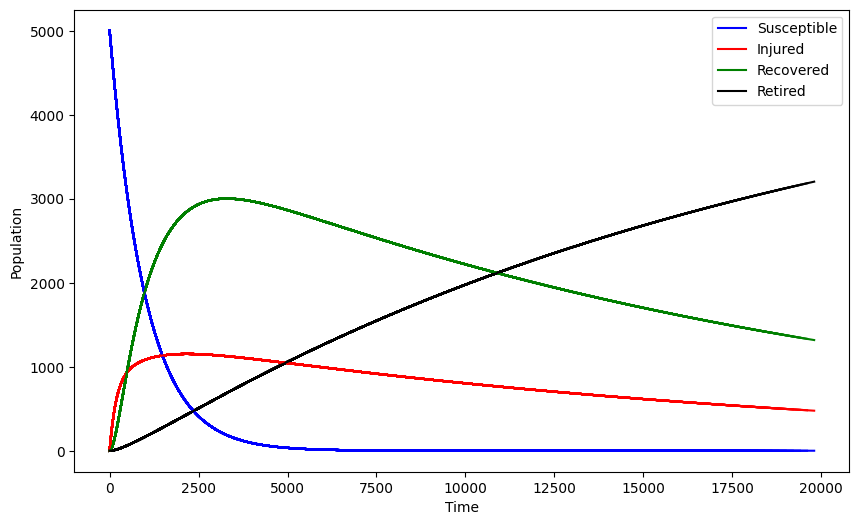

In [94]:
# Initialize the figure and axes
fig, ax = plt.subplots()
ax.set_xlabel('Time')
ax.set_ylabel('Population')
fig.set_size_inches(10, 6)

# Copy initial values
sus_euler = copy.copy(susceptible)
inj_euler = copy.copy(injured)
rec_euler = copy.copy(recovered)
ret_euler = copy.copy(retired)

# Initialize arrays for plotting
susceptible_values = [susceptible]
injured_values = [injured]
recovered_values = [recovered]
retired_values = [retired]

# Run simulation
for step in range(simulation_length):

    sus_euler, inj_euler, rec_euler, ret_euler = euler_step(sus_euler, inj_euler, rec_euler, ret_euler)

    susceptible_values.append(sus_euler)
    injured_values.append(inj_euler)
    recovered_values.append(rec_euler)
    retired_values.append(ret_euler)

    if step % 200 == 0:
        update_plot(ax, susceptible_values, injured_values, recovered_values, retired_values)
        if step == 0 : ax.legend()
        display(fig)

plt.close(fig)

##### Using The Second Order Runge-Kutta Method

In [ ]:
# def runge_kutta_step(sus, inj, rec, ret):

#     sus_k1 = new_susceptible(sus) * dt
#     inj_k1 = new_injured(sus, inj, rec) * dt
#     rec_k1 = new_recovered(inj, rec) * dt

#     sus_k2 = new_susceptible(sus + sus_k1/2) * dt
#     inj_k2 = new_injured(sus + sus_k1/2, inj + inj_k1/2, rec + rec_k1/2) * dt
#     rec_k2 = new_recovered(inj + inj_k1/2, rec + rec_k1/2) * dt
#     ret_k2 = new_retired(inj + inj_k1/2) * dt
    
#     sus = runge_kutta_2(new_susceptible, sus, dt)
#     inj = runge_kutta_2(new_injured, sus, dt)
#     rec = runge_kutta_2(new_recovered, sus, dt)
#     ret = runge_kutta_2(new_retired, sus, dt)
    
#     return sus, inj, rec, ret

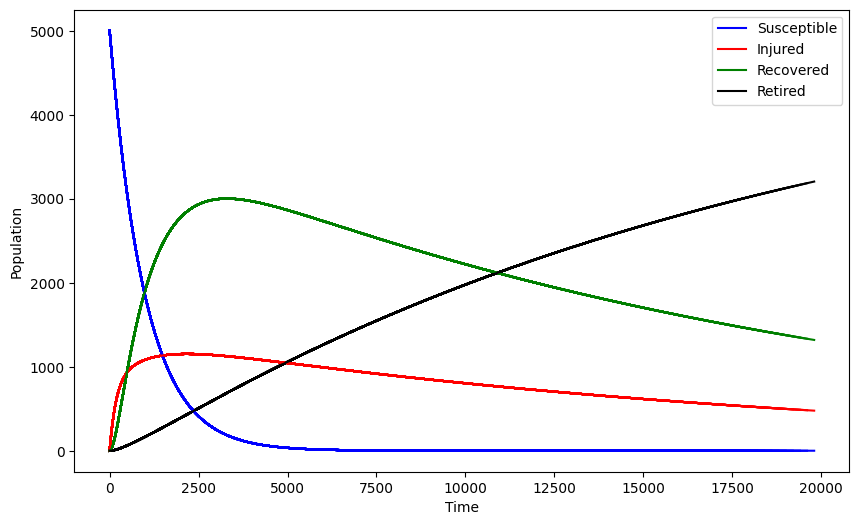

In [97]:
# Initialize the figure and axes
fig, ax = plt.subplots()
ax.set_xlabel('Time')
ax.set_ylabel('Population')
fig.set_size_inches(10, 6)

# Copy initial values
sus_rk2 = copy.copy(susceptible)
inj_rk2 = copy.copy(injured)
rec_rk2 = copy.copy(recovered)
ret_rk2 = copy.copy(retired)

# Initialize arrays for plotting
susceptible_values = [susceptible]
injured_values = [injured]
recovered_values = [recovered]
retired_values = [retired]

# Run simulation
for step in range(simulation_length):

    sus_k1 = new_susceptible(sus_rk2) * dt
    inj_k1 = new_injured(sus_rk2, inj_rk2, rec_rk2) * dt
    rec_k1 = new_recovered(inj_rk2, rec_rk2) * dt
    ret_k1 = new_retired(inj_rk2) * dt


    sus_k2 = new_susceptible(sus_rk2 + sus_k1/2) * dt
    inj_k2 = new_injured(sus_rk2 + sus_k1/2, inj_rk2 + inj_k1/2, rec_rk2 + rec_k1/2) * dt
    rec_k2 = new_recovered(inj_rk2 + inj_k1/2, rec_rk2 + rec_k1/2) * dt
    ret_k2 = new_retired(inj_rk2 + inj_k1/2) * dt

    sus_rk2 += sus_k2
    inj_rk2 += inj_k2
    rec_rk2 += rec_k2
    ret_rk2 += ret_k2

    susceptible_values.append(sus_rk2)
    injured_values.append(inj_rk2)
    recovered_values.append(rec_rk2)
    retired_values.append(ret_rk2)

    if step % 200 == 0:
        update_plot(ax, susceptible_values, injured_values, recovered_values, retired_values)
        if step == 0 : ax.legend()
        display(fig)

plt.close(fig)

### Regression Model

##### Logistic Regression Model
$$\hat{y} = \frac{1}{1 + e^{-X\theta}}$$

In [ ]:
def logistic_regression(X, theta):
    z = np.dot(X, theta)
    # Use np.clip to avoid values that lead to numerical instability
    z = np.clip(z, -20, 20)
    return 1 / (1 + np.exp(-z))

##### Compute Gradient
$$\nabla_\theta J(\theta) = \frac{1}{m} X^T(\hat{y} - y)$$

In [ ]:
def compute_gradient_logistic(X, y, theta):
    predictions = logistic_regression(X, theta)
    error = predictions - y
    gradient = np.dot(X.T, error) / len(y)
    return gradient

##### Compute Loss
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(\hat{y}^{(i)}) + (1 - y^{(i)}) \log(1 - \hat{y}^{(i)})]$$

In [ ]:
def logistic_loss(X, y, theta):
    predictions = logistic_regression(X, theta)
    # Clip predictions to avoid log(0)
    eps = 1e-15
    predictions = np.clip(predictions, eps, 1 - eps)
    return -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))

##### Gradient Descent using Euler Method

In [ ]:
def gradient_descent_euler_logistic(X, y, theta, learning_rate, iterations):
    history = []  # to store the history of the cost function
    for _ in range(iterations):
        grad = compute_gradient_logistic(X, y, theta)
        theta = theta - learning_rate * grad
        history.append(logistic_loss(X, y, theta))
    return theta, history

##### Gradient Descent using Runge-Kutta 2nd Order Method

In [ ]:
def gradient_descent_runge_kutta_2_logistic(X, y, theta, learning_rate, iterations):
    history = []  # to store the history of the cost function
    for _ in range(iterations):
        k1 = compute_gradient_logistic(X, y, theta)
        k2 = compute_gradient_logistic(X, y, theta - learning_rate * k1)
        theta = theta - (learning_rate / 2) * (k1 + k2)
        history.append(logistic_loss(X, y, theta))
    return theta, history

##### Simulation

In [ ]:
# # Generate a classification dataset
# X, y = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Add intercept
# X_train = np.c_[np.ones(X_train.shape[0]), X_train]
# X_test = np.c_[np.ones(X_test.shape[0]), X_test]

# initialize empty lists
X_train, X_test, y_train, y_test = [], [], [], []


# load pickled data (after cleaning and splitting in data-cleaning.ipynb)
import pickle
with open('../data/running/pickles/X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('../data/running/pickles/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('../data/running/pickles/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('../data/running/pickles/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)



# Initial parameters
theta_initial = np.zeros(X_train.shape[1])
learning_rate = 0.05
iterations = 1000


# Train the model using Euler and Runge-Kutta methods
theta_euler, history_euler = gradient_descent_euler_logistic(X_train, y_train, theta_initial, learning_rate, iterations)
theta_rk2, history_rk2 = gradient_descent_runge_kutta_2_logistic(X_train, y_train, theta_initial, learning_rate, iterations)

# Make predictions
# y_pred_euler = logistic_regression(X_test, theta_euler) >= 0.5
# y_pred_rk2 = logistic_regression(X_test, theta_rk2) >= 0.5

# Hyperparameter tuning of learning rate and iterations to find minimum loss, use multithreading to speed up
import multiprocessing as mp
import time


min_loss = np.inf
best_learning_rate = 0
best_iterations = 0
best_theta_euler = []
best_theta_rk2 = []
best_history_euler = []
best_history_rk2 = []

for learning_rate in [0.01, 0.05, 0.1, 0.5, 1]:
    for iterations in [100, 200, 500, 1000, 2000]:
        start = time.time()
        theta_euler, history_euler = gradient_descent_euler_logistic(X_train, y_train, theta_initial, learning_rate, iterations)
        theta_rk2, history_rk2 = gradient_descent_runge_kutta_2_logistic(X_train, y_train, theta_initial, learning_rate, iterations)
        end = time.time()
        print("Learning rate: ", learning_rate, "Iterations: ", iterations, "Time taken: ", end - start)
        print("Euler loss: ", history_euler[-1], "RK2 loss: ", history_rk2[-1])
        #if loss is minimum, save the parameters
        if min_loss > history_euler[-1] and min_loss > history_rk2[-1]:
            print("Minimum loss: ", min_loss, "Best iterations: ", best_iterations, "Best learning rate: ", best_learning_rate)
            min_loss = min(history_euler[-1], history_rk2[-1])
            best_iterations = iterations
            best_learning_rate = learning_rate
            best_theta_euler = theta_euler
            best_theta_rk2 = theta_rk2
            best_history_euler = history_euler
            best_history_rk2 = history_rk2

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)


X_train shape:  (322, 40)
X_test shape:  (139, 40)
y_train shape:  (322,)
y_test shape:  (139,)
Learning rate:  0.01 Iterations:  100 Time taken:  0.26695990562438965
Euler loss:  0.08404891165936279 RK2 loss:  0.060252265052322326
Minimum loss:  inf Best iterations:  0 Best learning rate:  0
Learning rate:  0.01 Iterations:  200 Time taken:  0.5277507305145264
Euler loss:  0.0409271643851009 RK2 loss:  0.03942320665931866
Minimum loss:  0.060252265052322326 Best iterations:  100 Best learning rate:  0.01
Learning rate:  0.01 Iterations:  500 Time taken:  1.3487355709075928
Euler loss:  0.011367953229227082 RK2 loss:  0.062111803958513075
Learning rate:  0.01 Iterations:  1000 Time taken:  2.6981494426727295
Euler loss:  0.0014463427414830624 RK2 loss:  0.01633244701989859
Minimum loss:  0.03942320665931866 Best iterations:  200 Best learning rate:  0.01
Learning rate:  0.01 Iterations:  2000 Time taken:  5.3972487449646
Euler loss:  0.0007131650083168137 RK2 loss:  0.00045988147413770

l:\Documents\(9) Cairo Uni Fall 2023\Modelling\Tasks & Projects\Term Project\injury-dynamics-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
l:\Documents\(9) Cairo Uni Fall 2023\Modelling\Tasks & Projects\Term Project\injury-dynamics-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
l:\Documents\(9) Cairo Uni Fall 2023\Modelling\Tasks & Projects\Term Project\injury-dynamics-model\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicte

Optimal threshold: 0.0
F1 score: 0.014285714285714287
Accuracy (Euler Method): 0.007194244604316547
Accuracy (Runge-Kutta 2nd Order Method): 0.007194244604316547


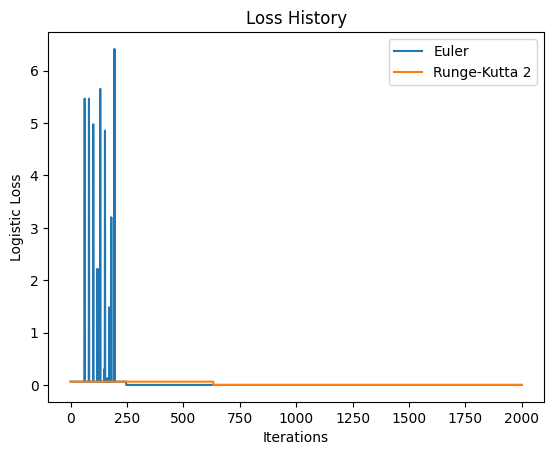

In [ ]:
# Optimize the threshold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

# Initialize empty lists
thresholds = []
f1_scores = []
precisions = []

# Find the optimal threshold
for threshold in np.arange(0, 1, 0.01):
    y_pred_euler = logistic_regression(X_test, best_theta_euler) >= threshold
    f1 = f1_score(y_test, y_pred_euler)
    precision = precision_score(y_test, y_pred_euler)
    thresholds.append(threshold)
    f1_scores.append(f1)
    precisions.append(precision)

# Convert to numpy arrays
thresholds = np.array(thresholds)
f1_scores = np.array(f1_scores)
precisions = np.array(precisions)

# Find the threshold that maximizes F1 score
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)
print("F1 score:", f1_scores[optimal_idx])

# Predict using optimal threshold
y_pred_euler = logistic_regression(
    X_test, best_theta_euler) >= optimal_threshold
y_pred_rk2 = logistic_regression(X_test, best_theta_rk2) >= optimal_threshold

# Calculate accuracy
accuracy_euler = accuracy_score(y_test, y_pred_euler)
accuracy_rk2 = accuracy_score(y_test, y_pred_rk2)

print("Accuracy (Euler Method):", accuracy_euler)
print("Accuracy (Runge-Kutta 2nd Order Method):", accuracy_rk2)

# Plotting the loss history
plt.plot(history_euler, label='Euler')
plt.plot(history_rk2, label='Runge-Kutta 2')
plt.xlabel('Iterations')
plt.ylabel('Logistic Loss')
plt.title('Loss History')
plt.legend()
plt.show()

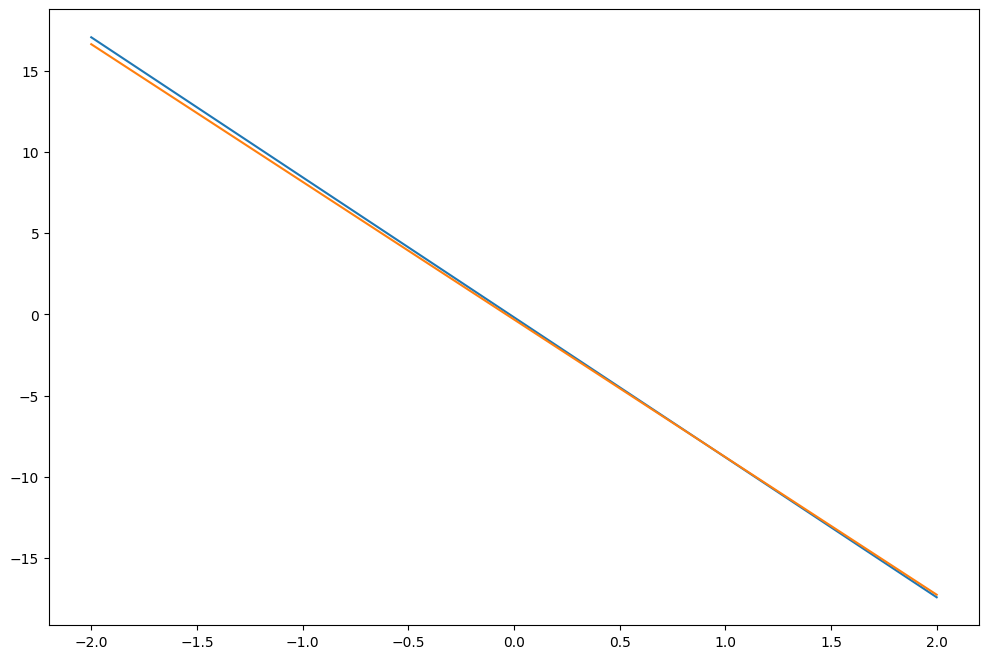

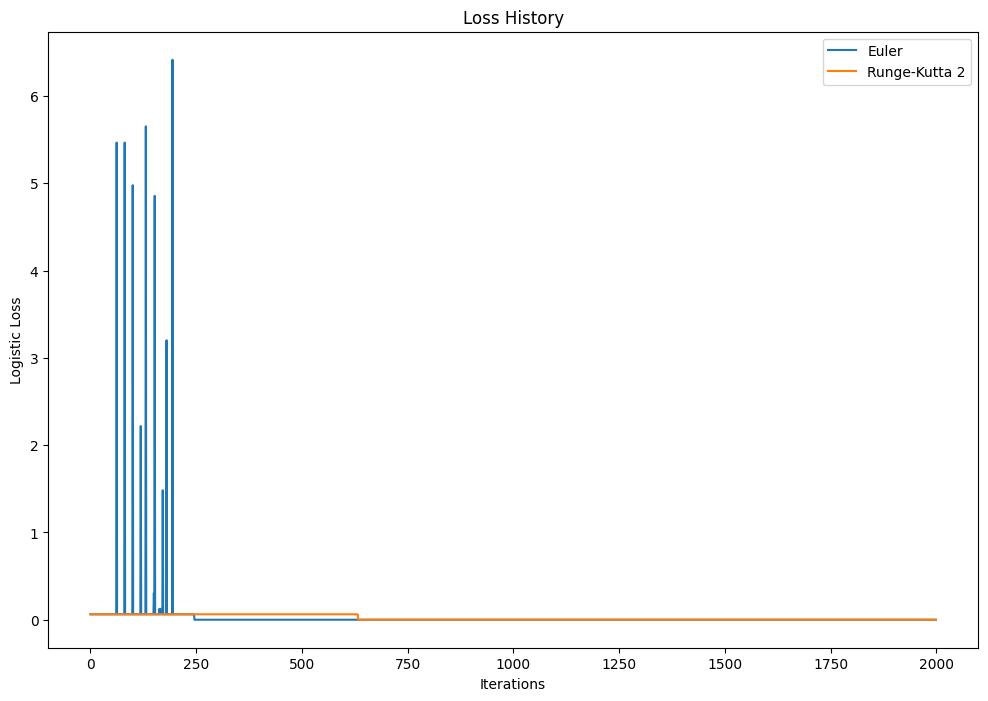

In [ ]:
# Visualize predictions and their accuracy on the test set

# Plot the decision boundary
x1 = np.linspace(-2, 2, 10)
x2 = -(theta_euler[0] + theta_euler[1] * x1) / theta_euler[2]

plt.figure(figsize=(12, 8))
plt.plot(x1, x2, label='Euler')

x2 = -(theta_rk2[0] + theta_rk2[1] * x1) / theta_rk2[2]
plt.plot(x1, x2, label='Runge-Kutta 2')



# Plot the accuracy
plt.figure(figsize=(12, 8))
plt.plot(history_euler, label='Euler')
plt.plot(history_rk2, label='Runge-Kutta 2')
plt.xlabel('Iterations')
plt.ylabel('Logistic Loss')
plt.title('Loss History')
plt.legend()
plt.show()


